In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

In [40]:
tickerSymbol = 'AZN'

In [41]:
tickerData = yf.Ticker(tickerSymbol)

In [42]:
#get the historical prices for this ticker
tickerDf = tickerData.history(interval='1d', start='2019-1-1', end='2020-4-30')

In [43]:
priceData = tickerDf.Open

In [44]:
priceData = priceData.asfreq(pd.infer_freq(priceData.index))

In [45]:
priceData

Date
2019-01-02 00:00:00-05:00    33.734576
2019-01-03 00:00:00-05:00    34.324837
2019-01-04 00:00:00-05:00    34.718350
2019-01-05 00:00:00-05:00          NaN
2019-01-06 00:00:00-05:00          NaN
                               ...    
2020-04-25 00:00:00-04:00          NaN
2020-04-26 00:00:00-04:00          NaN
2020-04-27 00:00:00-04:00    48.675974
2020-04-28 00:00:00-04:00    49.345612
2020-04-29 00:00:00-04:00    49.062669
Freq: D, Name: Open, Length: 484, dtype: float64

Text(0.5, 1.0, 'AZN Price Data')

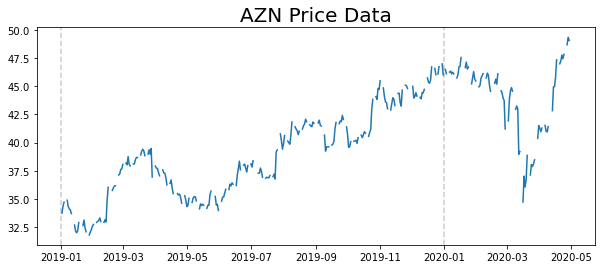

In [46]:
plt.figure(figsize=(10,4))
plt.plot(priceData)
for year in range(priceData.index[0].year, priceData.index[-1].year+1):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.2)
plt.title("%s Price Data"%tickerSymbol, fontsize=20)

In [47]:
def get_buying_selling_days(price_data, b, s):
    
    pct_change = price_data.pct_change()[1:]
    
    def buying_condition(sub_series):
        return (sub_series > 0).all()
    
    def selling_condition(sub_series):
        return (sub_series < 0).all()
    
    buying_days = pct_change.rolling(b).apply(buying_condition)
    
    potential_selling_days = pct_change.rolling(s).apply(selling_condition)
    
    return {'buying_days': buying_days, 'potential_selling_days': potential_selling_days}

In [48]:
info_dict = get_buying_selling_days(priceData, 2, 1)

In [49]:
buying_days = info_dict['buying_days']
potential_selling_days = info_dict['potential_selling_days']

In [50]:
df_stocks = pd.DataFrame(index = buying_days.index)

In [51]:
df_stocks['buying_day'] = (buying_days == 1)
df_stocks['potential_selling_day'] = (potential_selling_days == 1)
df_stocks['price'] = priceData
df_stocks = df_stocks[(df_stocks.buying_day | df_stocks.potential_selling_day)]

In [52]:
df_stocks

,buying_day,potential_selling_day,price
Date,,,
2019-01-04 00:00:00-05:00,True,False,34.718350
2019-01-08 00:00:00-05:00,False,True,34.324835
2019-01-09 00:00:00-05:00,False,True,34.119144
2019-01-10 00:00:00-05:00,False,True,34.020769
2019-01-11 00:00:00-05:00,False,True,33.689857
...,...,...,...
2020-04-20 00:00:00-04:00,False,True,46.987739
2020-04-22 00:00:00-04:00,True,False,47.761117
2020-04-23 00:00:00-04:00,False,True,47.431016


In [53]:
def check_cumulative_percent_change(price_data, buy_date, potential_sell_date):
    
    pct_change = price_data.pct_change()[1:]
    
    sub_series = 1 + pct_change[buy_date + timedelta(hours=1): potential_sell_date]
    
    return sub_series.product() > 1

In [54]:
def get_investing_result(df_stocks, starting_funds, verbose=False):
    
    #get a copy of price data
    price_data = df_stocks.price
    
    #at start, not holding any shares
    holding = False
    
    #init vars
    current_funds = starting_funds
    current_shares = 0
    last_buy_date = None
    
    #init dict of buying and selling dates
    events_list = []
    
    #for each buying day and potential selling day...
    for date,data in df_stocks.iterrows():
        
        #if not currently holding shares, and this is a buying day...
        if (not holding) and data.buying_day:
            
            #calculate the number of shares we can buy
            num_shares_to_buy = int(current_funds / data.price)
            
            #update number of shares
            current_shares += num_shares_to_buy
            
            #decrease current funds
            current_funds -= num_shares_to_buy * data.price
            
            #set last buy date
            last_buy_date = date
            events_list.append(('b', date))
            
            #we are now holding shares
            holding = True
            
            if verbose:
                print('Bought %s shares at $%s on %s totaling $%s'%(num_shares_to_buy, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
        
        #if you are holding shares, and this is a potential selling day...
        elif holding and data.potential_selling_day:
            
            #check to make sure we're making a profit
            if check_cumulative_percent_change(price_data, last_buy_date, date):
                #add to our current funds
                current_funds += current_shares * data.price
                
                if verbose:
                    print('Sold %s shares at $%s on %s totaling $%s'%(current_shares, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
                    print('--------------------------------------')
                    
                #reset current shares
                current_shares = 0
                
                #we are no longer holding shares
                holding = False
                
                events_list.append(('s', date))
                
    #get the stock price at the end of the time span
    final_stock_price = price_data[-1]
        
    #get the final total value of all assets (funds + stock value)
    final_value = current_funds + final_stock_price * current_shares
    
    #return the percent change in value
    return round((final_value - starting_funds) / starting_funds,2), events_list

In [55]:
percent_change, events_list = get_investing_result(df_stocks, 10000, True)

Bought 288 shares at $34.71835011100155 on 2019-01-04 totaling $9998.88
Sold 288 shares at $35.74684821513682 on 2019-02-19 totaling $10295.09
--------------------------------------
Bought 284 shares at $36.14035402557369 on 2019-02-21 totaling $10263.86
Sold 284 shares at $38.02093606902491 on 2019-03-05 totaling $10797.95
--------------------------------------
Bought 279 shares at $38.67961809939359 on 2019-03-14 totaling $10791.61
Sold 279 shares at $39.255969781585044 on 2019-03-21 totaling $10952.42
--------------------------------------
Bought 279 shares at $39.35660215238211 on 2019-03-26 totaling $10980.49
Sold 279 shares at $40.161667089654685 on 2019-07-30 totaling $11205.11
--------------------------------------
Bought 276 shares at $40.61908787413167 on 2019-08-02 totaling $11210.87
Sold 276 shares at $41.40005723599082 on 2019-08-12 totaling $11426.42
--------------------------------------
Bought 275 shares at $41.492489145692645 on 2019-08-20 totaling $11410.43
Sold 275 s

In [56]:
print(percent_change)

0.35


(30.0, 51.0)

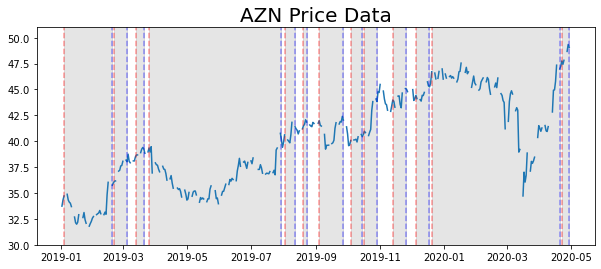

In [57]:
plt.figure(figsize=(10,4))
plt.plot(priceData)

y_lims = (int(priceData.min()*.95), int(priceData.max()*1.05))
shaded_y_lims = int(priceData.min()*.5), int(priceData.max()*1.5)

for idx, event in enumerate(events_list):
    color = 'red' if event[0] == 'b' else 'blue'
    plt.axvline(event[1], color=color, linestyle='--', alpha=0.4)
    if event[0] == 's':
        plt.fill_betweenx(range(*shaded_y_lims), 
                          event[1], events_list[idx-1][1], color='k', alpha=0.1)

plt.title("%s Price Data"%tickerSymbol, fontsize=20)
plt.ylim(*y_lims)